# 16. 백테스팅 시뮬레이션

백테스트란 현재 생각하는 전략을 과거부터 실행했을 때 어떠한 성과가 발생하는지 테스트해보는 과정입니다. 과거의 데이터를 기반으로 전략을 실행하는 퀀트 투자에 있어서 이는 핵심 단계이기도 합니다. 백테스트 결과를 통해 해당 전략의 손익뿐만 아니라 각종 위험을 대략적으로 판단할 수 있으며, 어떤 구간에서 전략이 좋았는지 혹은 나빴는지에 대한 이해도 키울 수 있습니다. 이러한 이해를 바탕으로 퀀트 투자를 지속한다면 단기적으로 수익이 나쁜 구간에서도 그 이유에 대한 객관적인 안목을 키울 수 있으며, 확신을 가지고 전략을 지속할 수 있습니다.

그러나 백테스트를 아무리 보수적으로 혹은 엄밀하게 진행하더라도 이미 일어난 결과를 대상으로 한다는 사실은 변하지 않습니다. 백테스트 수익률만을 보고 투자에 대해 판단하거나, 혹은 동일한 수익률이 미래에도 반복될 것이라고 믿는다면 이는 백미러만 보고 운전하는 것처럼 매우 위험한 결과를 초래할 수도 있습니다.

파이썬에는 백테스트를 위한 수많은 패키지들이 존재하지만 대표적인 패키지는 다음과 같습니다.

- backtesting: 각종 트레이딩 전략에 최적화된 인터페이스를 제공하며, 앞서 살펴본 TA-Lib 패키지와의 상당한 호환성 및 파라미터에 대한 최적화 기능도 제공합니다. 
```
https://kernc.github.io/backtesting.py/
```

- Backtrader: 구글에서 파이썬 관련 백테스트를 검색하면 가장 많이 검색되는 패키지일 만큼 사용법에 대한 메뉴얼이 잘 구성되어 있습니다. 
```
https://www.backtrader.com/
```

- bt: 앞의 패키지들과는 다르게 트레이딩 전략 뿐만 아니라 포트폴리오 기반의 퀀트를 백테스트를 하는데도 매우 유용한 기능들을 제공합니다.
```
https://pmorissette.github.io/bt/
```

모든 패키지에는 장단점이 있기 마련이기에, 모두 사용해보고 본인에게 맞는것을 선택하는 것이 최고의 방법입니다. 본 책에서는 포트폴리오 전략과 트레이딩 전략을 동시에 다루기에 **bt** 패키지를 사용해 백테스트를 하도록 하겠습니다. 해당 패키지에는 본 책에서 다루는 내용 외에도 백테스트 및 결과 평가에 대한 수많은 함수들이 존재하기에, 공식 페이지와 github의 코드를 모두다 뜯어보는 것도 재밌는 작업입니다.

또한 본 패키지의 함수는 대부분 **ffn** 패키지를 기초로 하므로 이 역시 찾아보는 것이 추천드립니다.

```
http://pmorissette.github.io/ffn/
```

## 16.1 bt 패키지 

bt 패키지에서는 백테스트의 과정을 다음과 같이 정의합니다.

1. 가격 데이터의 수집
2. 전략의 정의
3. 데이터를 이용한 전략의 백테스트
4. 결과에 대한 평가

이 중 본 장에서는 1번에서 3번까지의 과정에 대해 자세히 다루도록 하겠으며, 4번 결과에 대한 평가는 본 장에서는 간략하게 다루며, 다음장에서 더욱 자세히 다루도록 하갰습니다.

### 16.1.1 가격 데이터의 수집

백테스트를 위해서는 먼저 가격 데이터를 준비해야 합니다. bt 패키지의 `get()` 함수는 야후 파이낸스 API를 이용해 수정주가를 다운로드 받을 수 있게 해줍니다.

In [1]:
import bt

data = bt.get("SPY, TLT", start = '2003-01-01', end = '2020-12-31')
data.head()

,spy,tlt
Date,,
2002-12-31,60.898785,46.685986
2003-01-02,62.859028,45.478878
2003-01-03,63.052299,45.584309
2003-01-06,64.163559,45.463108
2003-01-07,64.004807,45.626480


`get()` 패키지 내에 다운로드 받고자 하는 종목의 티커를 입력하면 수정주가만 데이터프레임 형태로 가공됩니다. 물론 앞에서 살펴본 크롤링, API 등을 이용해 다운로드 받은 데이터를 이용해 백테스를 해도 되며, 본 장에서는 앞서 다운로드 받은 글로벌 자산을 대표하는 ETF 데이터를 사용하겠습니다.

In [2]:
import pandas as pd

prices = pd.read_csv('data/asset_data.csv', index_col = 0)
prices.index = pd.to_datetime(prices.index)

### 16.1.2 전략의 정의

두번째로 시뮬레이션 하고자 하는 백테스트가 어떤 것인지를 정의해야 합니다. 10개 자산을 동일비중으로 투자하며, 매월 말 리밸런싱 하는 전략을 정의해보도록 하겠습니다. `Strategy()` 함수 내에 algos 모듈을 이용해 백테스트 하고자 하는 내용을 입력합니다.

In [3]:
# 전체 자산 동일비중, 매월 말 리밸런싱
strategy = bt.Strategy("Asset_EW",
                       [bt.algos.SelectAll(),
                        bt.algos.WeighEqually(),
                        bt.algos.RunMonthly(),
                        bt.algos.Rebalance()
                       ])

1. 먼저 전략의 이름(Asset_EW)을 입력합니다.
2. `bt.algos.SelectAll()` 함수를 통해 모든 데이터를 사용함을 정의합니다.
3. `bt.algos.WeighEqually()` 함수를 통해 동일비중을 정의합니다.
4. `bt.algos.RunMonthly()` 함수를 통해 매월말 리밸런싱 함을 정의합니다.
5. `bt.algos.Rebalance()` 함수를 통해 계산된 비중에 따라 리밸런싱 함을 정의합니다.

이 외에 algos 모듈을 통해 다양한 백테스트 로직을 정의할 수 있으며, 자세한 내용은 아래 사이트에서 확인할 수 있습니다.

```
https://pmorissette.github.io/bt/bt.html#module-bt.algos
```


### 16.1.3 전략의 백테스트

앞에서 정의된 내용을 바탕으로 백테스트를 실행하도록 하겠습니다.

In [4]:
data = prices.dropna()

# 백테스트 생성
backtest = bt.Backtest(strategy, data)

# 백테스트 실행
result = bt.run(backtest)

1. 가격 데이터 중 ETF의 시작 시점이 모두 다르므로, `dropna()` 함수를 통해 NA를 모두 제거하여 시작시점을 동일하게 만듭니다.
2. `Backtest()` 함수를 통해 백테스트를 생성할 수 있으며, 앞에서 정의한 백테스트 내용된 가격 데이터를 입력합니다.
3. `run()` 함수를 통해 백테스트를 실행하며, 앞에서 생성된 백테스트를 입력합니다.

## 16.1.4 결과에 대한 평가

위 과정을 통해 시뮬레이션 된 백테스트의 결과를 살펴보도록 하겠습니다.

In [5]:
result.prices

,Asset_EW
2006-12-18,100.000000
2006-12-19,100.000000
2006-12-20,100.208564
2006-12-21,100.077634
2006-12-22,100.038885
...,...
2021-04-12,211.231709
2021-04-13,212.561644
2021-04-14,212.866016
2021-04-15,215.040685


백테스트 결과에서 `price`를 입력하면 누적수익률이 데이터프레임 형태로 나타며, 시작시점을 100으로 환산하여 계산됩니다.

In [6]:
result.prices.to_returns()

,Asset_EW
2006-12-18,NaN
2006-12-19,0.000000
2006-12-20,0.002086
2006-12-21,-0.001307
2006-12-22,-0.000387
...,...
2021-04-12,-0.001979
2021-04-13,0.006296
2021-04-14,0.001432
2021-04-15,0.010216


`prices`에 추가로 `to_returns()`를 입력하면, 수익률이 계산됩니다.

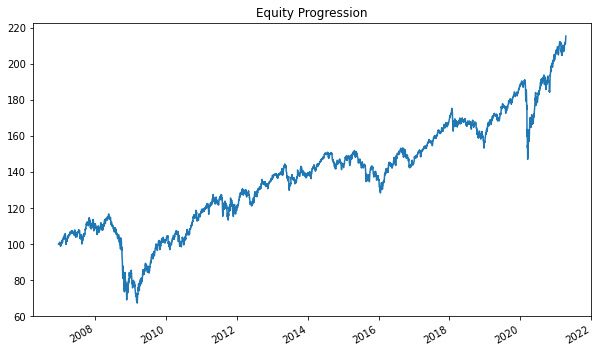

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

result.plot(figsize = (10, 6), legend = False)
plt.show()

`plot()` 함수를 통해 누적수익률을 그래프로 나타낼 수도 있습니다.

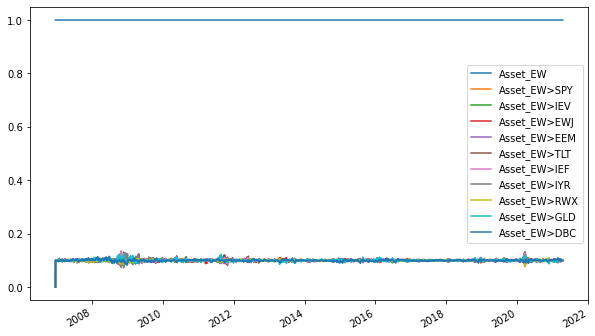

In [8]:
result.plot_weights(figsize = (10, 6))

`plot_weights()` 함수를 통해 각 종목 별 투자 비중을 구할 수도 있습니다. 그러나 비중이 겹쳐 잘 보이지 않으므로, matplotlib 패키지를 이용해 꾸며보도록 하겠습니다. 

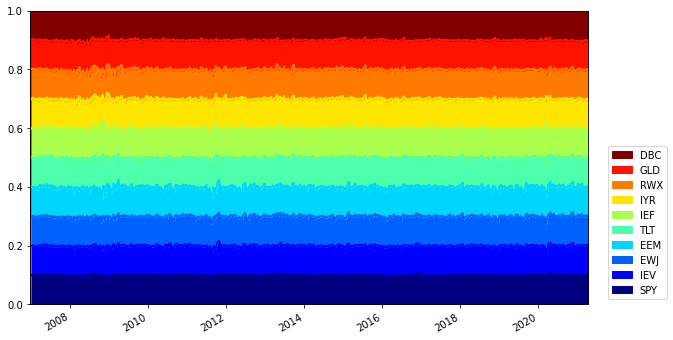

In [9]:
from matplotlib import cm

ax = result.get_security_weights().plot.area(figsize = (10, 6), ylim = [0, 1], legend = False, colormap = cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right', bbox_to_anchor=(1.15, 0))
plt.show()

종목별 투자비중은 `get_security_weights()` 함수를 통해 데이터프레임 형태로 구할 수 있으며, 이를 그림으로 나타내주도록 합니다. 매월 말 리밸런싱을 하므로, 대부분의 구간에서 모든 자산에 10%씩 균등하게 투자됩니다.

In [10]:
result.stats.head(10)

,Asset_EW
start,2006-12-18 00:00:00
end,2021-04-16 00:00:00
rf,0
total_return,1.15357
cagr,0.0550029
max_drawdown,-0.423533
calmar,0.129867
mtd,0.0372992
three_month,0.0430328
six_month,0.12863


마지막으로 `stats`를 통해 각종 성과 측정치를 구할 수 있습니다. 성과 평가에 대해서는 다음 장에서 더욱 자세히 다루도록 하겠습니다. 

## 16.2 정적 자산배분: 올웨더 포트폴리오

자산배분은 포트폴리오 내에 다양한 자산에 분산 투자하여 위험을 줄이고 일정수준의 수익률 달성하고자 하는 방법입니다. 이러한 자산 배분은 크게 **정적 자산배분**과 **동적 자산배분**으로 나뉩니다. 

정적 자산배분은 주식과 채권 비중 등 자산에 대한 비중을 어떠한 시장 상황에서도 6:4 혹은 8:2로 배분하고 유지하는 전략을 말합니다. 대표적인 정적 자산배분 전략은 레이 달리오가 운용하는 기법으로 유명해진 올웨더 포트폴리오가 있습니다. 레이 달리오는 세계 최대 헤지펀드인 브릿지워터(Bridgewater Associate)의 설립자입니다. 그는 시시각각 변화는 경제 상황속에서 어떻게 자산배분을 해도 견딜수 있는 포트폴리오를 구상하였으며, 이것이 올웨더 포트폴리오 입니다. 경제환경은 크게 경제 성장률과 물가 상승률로 나눌 수 있으며, 각 국면마다 우수한 성과를 보이는 자산은 다릅니다.

```{figure} image/backtest_allweather.png
---
name: backtest_allweather
---
경제환경의 구분
```

1. 경제 성장률이 높은 구간에서는 위험 자산의 성과가 우수합니다.
2. 경제 성장률이 낮은 구간에서는 우량 채권의 성과가 우수합니다. 
3. 물가 상승률이 높은 구간에서는 원자재나 신흥국 채권의 성과가 우수합니다. 
4. 물가 상승률이 낮은 구간에서는 주식과 채권 모두 성과가 우수합니다.

올웨더 포트폴리오는 네 가지 상황 중 하나를 예측하기 보다는, 각각의 상황에 맞는 자산을 모두 포트폴리오에 담아 미리 대비합니다. 또한 각 상황이 올 확률이 25%씩 같다고 가정할 경우, 자산별 투자비중은 {numref}`backtest_aw`와 같습니다.

```{figure} image/backtest_aw.png
---
name: backtest_aw
---
올웨더 포트폴리오 투자 비중
```

### 16.2.1 올웨더 포트폴리오 백테스트

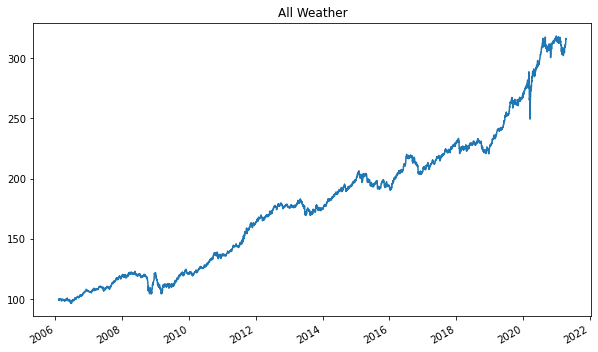

In [20]:
import bt

data = prices[['SPY', 'TLT', 'IEF', 'GLD', 'DBC']].dropna()

aw = bt.Strategy('All Weather',
                    [bt.algos.SelectAll(),
                     bt.algos.WeighSpecified(SPY = 0.3, TLT = 0.4, IEF = 0.15, GLD = 0.075, DBC = 0.075),
                     bt.algos.RunQuarterly(),
                     bt.algos.Rebalance()])
aw_backtest = bt.Backtest(aw, data)
aw_result = bt.run(aw_backtest)

aw_result.plot(figsize = (10, 6), title = 'All Weather', legend = False)
plt.show()

1. prices 데이터 중 주식, 장기채, 중기채, 금, 원자재에 해당하는 열만 선택합니다.
2. 전략을 정의해주며, `bt.algos.WeighSpecified()`에 각 자산별 비중을 직접 입력합니다. 또한 `bt.algos.RunQuarterly()`를 통해 분기별 리밸런싱을 정의합니다.
3. 백테스트를 생성 및 실행합니다.

누적 수익률을 확인해보면 다양한 자산에 분산되어 있기에 장기간 동안 꾸준히 상승하는 모습을 보입니다.

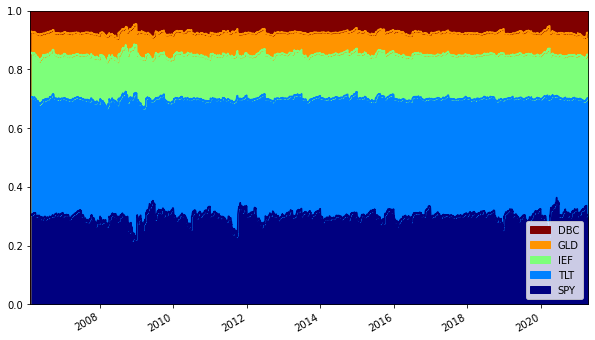

In [12]:
from matplotlib import cm

ax = aw_result.get_security_weights().plot.area(figsize = (10, 6), ylim = [0, 1], legend = False, colormap = cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')
plt.show()

분기 별로 리밸런싱이 이루어짐에 따라, 각 자산별 투자비중이 일정하게 유지됩니다.

## 16.3 동적 자산배분

정적 자산배분이 자산 별 일정 비중을 유지하는 전략이라면, 동적 자산배분은 시장 상황에 따라 투자하는 대상과 비중을 계속해서 변경하는 전략입니다. 여러 경제 상황에서 상대적으로 유리한 자산은 좋은 성과를 보일 것이며, 경제 국면은 장기간 지속되는 추세가 있으므로 모멘텀이 있는 자산에 투자하는 것이 현명한 방법일 수 있습니다. 모멘텀을 이용한 동적 자산배분 포트폴리오는 다음과 같이 구성됩니다.

1. 글로벌 10개 자산 중 과거 12개월 수익률이 높은 5개 자산을 선택합니다.
2. 위험균형 포트폴리오를 구성합니다.
3. 매월 말 리밸런싱을 실시합니다.

10개 자산에서 과거 수익률 기준 5개 자산만 선택하는 이유는 모멘텀 효과를 얻기 위해서 입니다. {numref}`mom_rank`는 글로벌 10개 자산의 과거 6개월 수익률을 기준으로 순위를 매기고, 이들의 다음 월 수익률이 상위 50%가 될 확률을 구한 값입니다. 수익률이 높은 1-5위 까지의 자산은 다음 월에도 수익률이 높을 확률이 50%가 넘지만, 수익률이 낮은 6-10위 까지의 자산은 다음 월에 수익률이 높을 확률이 50%가 되지 않습니다. 따라서 자산군 간에도 모멘텀 효과가 존재하며, 이를 활용하기 위해 5개 자산만을 선택해 투자합니다.

```{figure} image/mom_rank.png
---
name: mom_rank
---
자산군 내 모멘텀 효과
```

또한 위험균형 포트폴리오를 이용해 변동성이 지나치게 큰 자산에 의해 포트폴리오의 수익률이 크게 영향받는 일을 줄이고, 최대한 안정적으로 포트폴리오를 구성합니다.

### 16.3.1 동적 자산배분 백테스트¶

동적 자산배분의 로직이 다소 복잡해 보이지만, bt 패키지에 내장된 함수를 이용할 경우 역시나 매우 손쉽게 백테스트 할 수 있습니다.

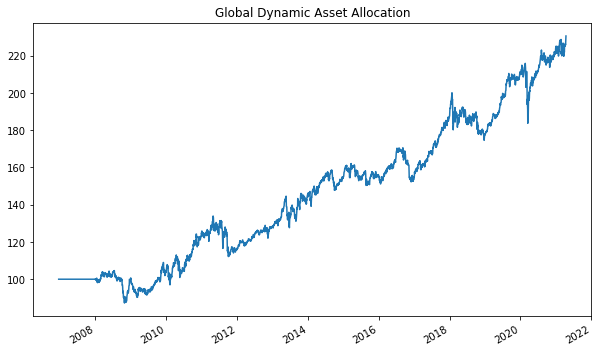

In [21]:
import bt
import matplotlib.pyplot as plt
%matplotlib inline

data = prices.dropna()

gdaa = bt.Strategy('GDAA', 
                   [bt.algos.SelectAll(),
                    bt.algos.SelectMomentum(n = 5,lookback = pd.DateOffset(years = 1)),
                    bt.algos.RunMonthly(),
                    bt.algos.WeighERC(lookback = pd.DateOffset(years = 1)),
                    bt.algos.Rebalance()
                   ])      

gdaa_backtest = bt.Backtest(gdaa, data)
gdaa_result = bt.run(gdaa_backtest)

gdaa_result.plot(figsize = (10, 6), title = 'Global Dynamic Asset Allocation', legend = False)
plt.show()

1. prices 데이터에서 NA를 제거합니다.
2. `bt.Strategy()` 내에 전략을 정의해줍니다.
    - `bt.algos.SelectAll()`: 전체 데이터를 선택합니다.
    - `bt.algos.SelectMomentum(n = 5,lookback = pd.DateOffset(years = 1))`: 모멘텀 상위 종목을 선택하며 개수는 5개, 모멘텀 관측 기간은 과거 1년을 합니다. 
    - `bt.algos.RunMonthly()`: 매월 리밸런싱을 실시합니다.
    - `bt.algos.WeighERC(lookback = pd.DateOffset(years = 1))`: ERC 즉 위험균형 포트폴리오를 구성하며, 분산-공분산 계산을 위한 수익률은 과거 1년 데이터를 이용합니다.
    - `bt.algos.Rebalance()`: 리밸런싱을 정의합니다.
3. 백테스트를 생성 및 실행합니다.

이처럼 algos 모듈 내의 각종 함수를 이용하면 다양한 전략을 손쉽게 정의 및 백테스트 할 수 있습니다.  

```{note}
그래프를 살펴보면 처음 1년간은 수익률에 변화가 없으며, 이는 모멘텀 관측을 위한 1년 간은 투자를 할 수 없기 때문입니다. 성과를 평가할 때는 이처럼 투자가 이루어지지 않는 기간을 제외하고 실제 투자가 이루어진 부분부터 평가해야 합니다.
```

### 16.3.2 거래 비용 고려하기

정적 자산배분과는 달리 동적 자산배분은 매 시점마다 투자하는 대상 및 투자비중이 변합니다. 

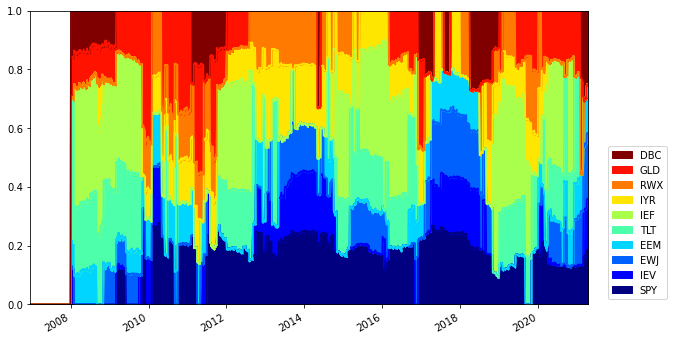

In [5]:
from matplotlib import cm

wt = gdaa_result.get_security_weights().reindex(columns = prices.columns)
ax = wt.plot.area(figsize = (10, 6), ylim = [0, 1], legend = False, colormap = cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right', bbox_to_anchor=(1.15, 0))
plt.show()

기존 정적 자산배분보다 투자 비중의 변화가 상당히 심한것을 확인할 수 있습니다. 이는 수익률 상위 5개에 해당하는 자산이 매월 말 바뀌며, 위험균형 포트폴리오를 구성하는 비중이 계속해서 바뀌기 때문입니다.

모델 포트폴리오의 경우 이러한 점을 신경쓰지 않아도 되지만, 실제 투자에서는 잦은 턴오버로 인한 매매비용, 세금, 기타비용 등이 매우 중요해집니다. 해당 전략의 턴오버를 살펴보도록 하겠습니다.

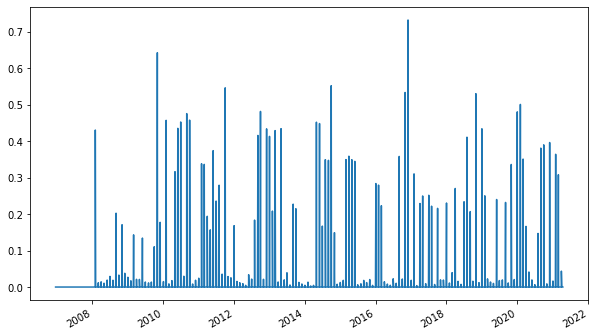

In [7]:
gdaa_backtest.turnover.plot(figsize = (10, 6), legend = False)
plt.show()

생성된 백테스트에서 `turnover`를 통해 턴오버를 구할 수 있습니다. 매월 상당한 턴오버가 발생하므로, 이를 고려한 수익률을 추가로 살펴볼 필요가 있습니다. 매수 혹은 매도당 발생하는 세금, 수수료, 시장충격 등 총 비용을 0.2%로 가정하여 백테스트를 실행하겠습니다.

In [8]:
gdaa_backtest_net = bt.Backtest(gdaa, data, name = 'GDAA_net', commissions = lambda q, p: abs(q) * p * 0.002)
gdaa_result = bt.run(gdaa_backtest, gdaa_backtest_net)

1. `bt.Backtest()` 함수 내에 기존에 정의된 백테스트인 gdaa를 그대로 사용하며, 이름만 **GDAA_net**으로 변경합니다. 또한 commissions 부분에 수수료를 계산하는 부분을 입력합니다. q는 quantity(주수), p는 price(주가)를 의미하며, 즉 총 거래 가격에서 0.2%가 수수료로 나간다고 가정합니다.
2. `bt.run()` 내에 기존에 생성된 백테스트 내용(gdaa_backtest)과 새롭게 생성된 백테스트 내용(gdaa_backtest_net)을 동시에 입력하면, 두 개의 백테스트가 한번에 실행됩니다.

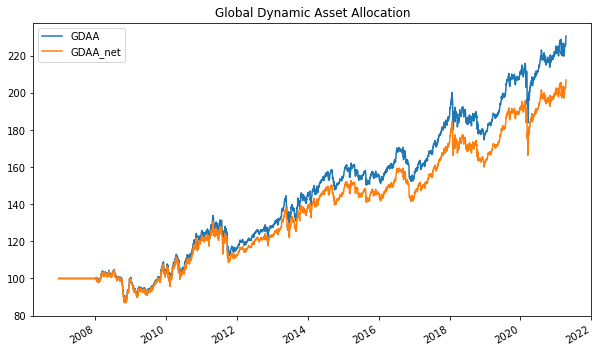

In [9]:
gdaa_result.prices.plot(figsize = (10, 6), title = 'Global Dynamic Asset Allocation')
plt.show()

기존의 비용을 고려하지 않은 포트폴리오(GDAA)에 비해, 비용을 차감한 포트폴리오(GDAA_net)의 수익률이 시간이 지남에 따라 서서히 감소합니다. 이러한 차이는 비용이 크거나 턴오버가 높을수록 더욱 벌어지게 됩니다

```{note}
실제 전문적인 백테스트에서는 매매비용을 일괄적으로 적용하기 보다는, 각 ETF별 매수-매도 스프레드 등 더욱 현실과 가까운 값을 적용합니다. 
```

## 16.4 추세추종 전략 백테스트

추세추종이란 주가가 동일한 방향으로 지속될 것이라는데 베팅하는 것입니다. 추세추종, 혹은 모멘텀 전략은 월스트리트에서 가장 오래된 투자전략 중 하나로써, 무려 1838년에 출간된 책에도 설명될 만큼 역사가 길고, 현재에도 가장 많이 사용되는 전략 중 하나입니다.

### 16.4.1 마켓 타이밍 전략

대표적인 추세추종 전략인 이동평균선을 이용한 트레이딩의 백테스트를 진행해보도록 하겠습니다. 메브 파버(Meb Faber)는 본인의 논문을 통해, 시점 선택(Market Timing) 전략을 사용할 경우 단순히 매수 후 보유하는 것 대비 극심한 하락장에서 낙폭을 줄일 수 있으며, 이로 인해 위험 대비 수익률을 올릴 수 있다고 설명합니다. 논문에서 말하는 시점 선택의 투자 규칙은 다음과 같습니다.

$$ 주가 > 10개월 이동평균 → 매수$$
$$ 주가 < 10개월 이동평균 → 매도\ 및\ 현금보유$$

즉 주가가 10개월 이동평균 보다 위에 있다는 것은 상승추세를 의미하므로 매수 포지션을, 10개월 이동평균 보다 아래에 있다는 것을 하락추세를 의미하므로 현금 보유를 통해 하락 방어를 하고자 합니다. 먼저 해당 규칙을 미국 S&P 500를 추종하는 SPY ETF에 적용하는 예제를 살펴보겠으며, 리밸런싱은 매월 실행합니다.

In [47]:
# SMA
import talib

data = prices[['SPY']].dropna()
sma = data.apply(lambda x: talib.SMA(x, 200))

먼저 `apply()` 함수 내부에 `SMA()`을 이용해 200일(10개월) 이동평균을 구해줍니다.

In [48]:
import bt

bt_sma = bt.Strategy('Timing', 
                     [bt.algos.SelectWhere(data > sma),
                      bt.algos.RunMonthly(),
                      bt.algos.WeighEqually(),
                      bt.algos.Rebalance()])
bt_sma_backtest = bt.Backtest(bt_sma, data)

`bt.algos.SelectWhere()`는 입력값이 True 일때만 투자를 하도록 정의합니다. 즉, data(SPY)가 sma(이동평균) 보다 클 때에만 투자를 합니다. 나머지는 위에서 살펴본 것들과 동일합니다.

In [49]:
def buy_and_hold(data, name):
    
    # Define the benchmark strategy
    bt_strategy = bt.Strategy(name, 
                              [bt.algos.RunOnce(),
                               bt.algos.SelectAll(),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])
    # Return the backtest
    return bt.Backtest(bt_strategy, data)

# Create benchmark strategy backtest
stock = buy_and_hold(data[['SPY']], name='stock')

bt_sma_result = bt.run(bt_sma_backtest, stock)

1. `buy_and_hold()` 함수를 통해 단순 매수 후 보유의 경우를 정의합니다. `bt.algos.RunOnce()`는 리밸런싱이 없이 처음 상태가 그대로 유지되는 것입니다.
2. SPY의 매수 후 보유 전략을 생성합니다.
3. 앞에서 생성된 추세추종 전략과, 매수 후 보유의 백테스트를 실행합니다.

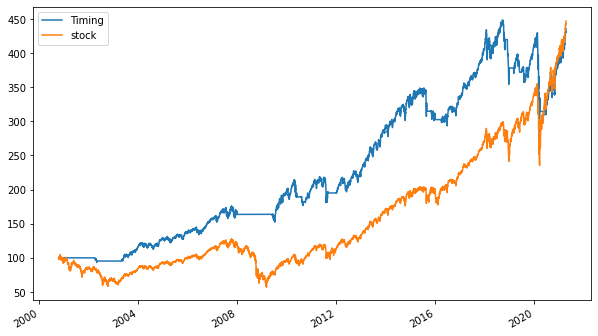

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

bt_sma_result.prices[200:].rebase().plot(figsize = (10, 6))
plt.show()

추세추종 전략의 경우 이동평균 계산을 위해 처음 200 일간은 투자가 되지 않으므로 매수 후 보유 전략과 시작 시점이 일치하지 않습니다. 따라서 두 전략 모두 200번째 날부터를 시작시점으로 삼아야 하며, `rebase()` 함수를 이용하여 선택된 데이터의 시작시점을 다시 100으로 만들어줍니다.

추세추종 전략을 사용할 경우 2000년 IT 버블이나 2008년 금융위기, 2020년 코로나 사태에서 하락폭이 제한됩니다. 즉 하락추세가 시작되면 주식을 모두 매도하여, 추가적인 하락을 방어합니다.

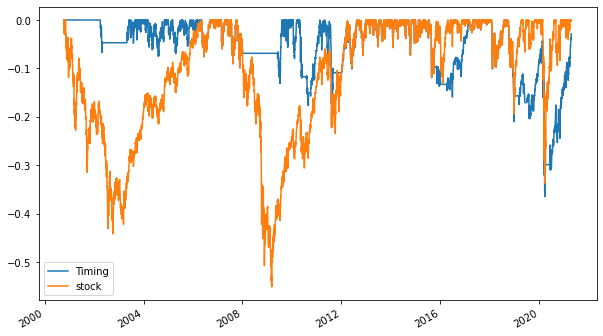

In [51]:
bt_sma_result.prices[200:].rebase().to_drawdown_series().plot(figsize = (10, 6))
plt.show()

`to_drawdown_series()` 함수는 낙폭(drawdown)을 계산해 줍니다. 추세추종 전략을 사용할 경우 하락 방어가 우수함이 확인됩니다.

### 16.4.2 파라미터 최적화

그렇다면 과연 200일(10개월) 이동평균을 사용하는 것이 최적일까요? 혹은 다른 값을 사용했을 때 수익률이 더 좋을수 있지 않을까요?

200일과 같이 변수를 파라미터(parameter)라 하며, 성과가 최대화 되는 파라미터를 찾는 것을 파라미터 최적화라고 합니다. 트레이딩에서 이러한 파라미터 최적화는 매우 중요한 작업입니다. 앞선 마켓 타이밍 전략에서 이동평균을 계산할 때 사용하는 일수를 변경해가며 수익률을 확인해보도록 하겠습니다.

In [52]:
# SMA
import talib
import bt

data = prices[['SPY']].dropna()

def timing(price, n):
    
    sma = price.apply(lambda x: talib.SMA(x, n))
    stragety = bt.Strategy(n,
                           [bt.algos.SelectWhere(price > sma),
                            bt.algos.RunMonthly(),
                            bt.algos.WeighEqually(),
                            bt.algos.Rebalance()])
    
    backtest = bt.Backtest(stragety, price)  
    
    return(backtest)

n_20 = timing(prices[['SPY']], 20)
n_60 = timing(prices[['SPY']], 60)
n_100 = timing(prices[['SPY']], 100)
n_120 = timing(prices[['SPY']], 120)
n_150 = timing(prices[['SPY']], 150)
n_200 = timing(prices[['SPY']], 200)
n_230 = timing(prices[['SPY']], 230)
n_250 = timing(prices[['SPY']], 250)

result = bt.run(n_20, n_60, n_100, n_120, n_150, n_200, n_230, n_250)

1. 이동평균을 계산한 후, 백테스트를 생성하는 부분을 `timing()` 함수로 작성합니다.
2. 20일부터 250일까지 이동평균을 이용한 마켓타이밍 모델의 백테스트를 생성합니다.
3. 모든 백테스트를 한번에 실행합니다.

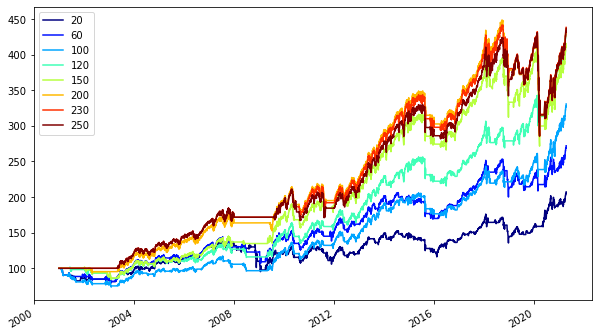

In [54]:
from matplotlib import cm

result.prices[250:].rebase().plot(figsize = (10, 6), colormap = cm.jet)
plt.show()

누적수익률을 확인해보면 단기 보다는 장기 이동평균을 사용할 수록 우수한 성과를 기록합니다. 그러나 예를들어 230일 이동평균이 최고의 수익률을 기록한다고 이것이 최적의 파라미터라고 말하기는 힘듭니다. 장기 이동평균을 사용하는 것이 단기 이동평균을 사용하는 것보다 성과가 좋은 이유는, 장기 이동평균이 장기적인 추세를 더 잘영하기 때문일 수 있습니다. 그러나 같은 장기 이동평균에서도 예를들어 230일이 210일 보다 우수한 것은 단순히 우연의 결과일 수 있으며, 백테스트 기간을 다르게 하면 전혀 다른 결과가 나타날 수도 있습니다.

백테스트 기간에서 최적화된 파라미터가 향후에도 최고의 수익률을 기록할 것이라는 생각은 위험할 수 있습니다. 백테스트에서는 엄청나게 우수한 성과를 보였던 전략을 찾아 용기있게 실제 투자에 나섰다가 과최적화의 저주에 빠져 실망스러운 수익률로 이어지는 경우도 종종 목겼했습니다. 따라서 모델에 사용되는 파라미터의 갯수는 최대한 작게, 그리고 인샘플(in-sample) 뿐만 아니라 아웃오브샘플(out-of-sample) 테스트에서도 뛰어난 성과를 보이는 파라미터를 택해야 하겠습니다.

### 16.4.3 롱숏 전략

지금까지는 주가가 이동평균선 위에 있을 때 매수하며 그렇지 않으면 매도하는 '롱온리' 전략에 대한 백테스트를 실시했습니다. 그러나 추세추종 전략은 상승추세에 대한 베팅뿐만 아니라 공매도, 인버스 ETF 혹은 선물매도 포지션을 통해 하락추세에도 베팅할 수 있습니다. 

흔히 단기 이동평균선이 중장기 이동평균선을 뚫고 올라가는 골든크로스의 경우 상승추세에 대한 신호를, 반대로 뚫고 내려가는 데드크로스의 경우 하락추세에 대한 신호를 나타냅니다. 과연 이러한 신호를 이용해 트레이딩 했을 때 성과가 어떤지 살펴보도록 하겠습니다.

In [59]:
import talib

data = prices[['SPY']]
EMA_200 = data.apply(lambda x: talib.EMA(x, 200))
EMA_60 = data.apply(lambda x: talib.EMA(x, 60))

먼저 장기추세에 해당하는 200일 지수 이동평균과 단기추세에 해당하는 60일 지수 이동평균을 구합니다.

In [60]:
signal = EMA_200.copy()
signal[EMA_60 >= EMA_200] = 1
signal[EMA_60 < EMA_200] = -1
signal[signal.isnull()] = 0

만일 60일 이동평균이 200일 이동평균보다 위에 있을 경우(골든크로스) 100% 투자 즉 매수를 하며, 반대의 경우(데드크로스) -100% 투자 즉 매도를 합니다. 이동평균을 계산하기 위한 처음 200일 부분은 데이터가 없으므로 포지션을 0으로 둡니다.

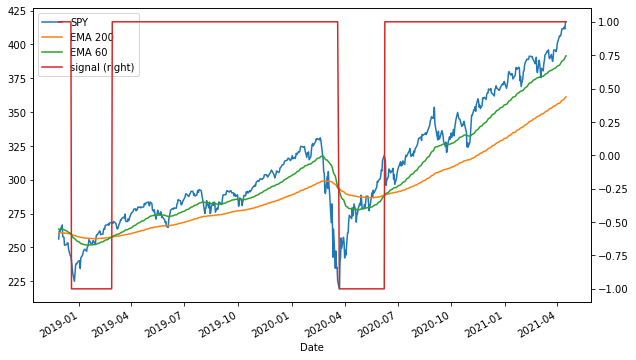

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

bind = pd.concat([data, EMA_200, EMA_60, signal], axis = 1)
bind.columns = ['SPY', 'EMA 200', 'EMA 60', 'signal']

bind.iloc[-600: ].plot(figsize = (10, 6), secondary_y = ['signal'])
plt.show()

주가와 각 이동평균선, 신호를 그림으로 나타내보면, 단기 이동평균선이 장기 이동평균선 위에 있을 경우에는 매수, 그렇지 않을 때는 매도를 하는 것이 확인됩니다. 이제 해당 전략의 백테스트를 실시해보겠습니다.

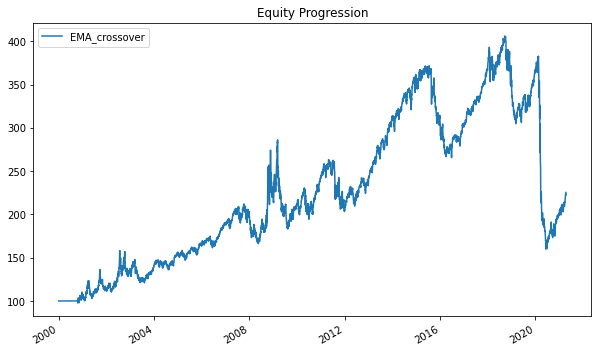

In [83]:
import bt

strategy = bt.Strategy('EMA_crossover', 
                       [bt.algos.WeighTarget(signal),
                        bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize = (10, 6))
plt.show()

`bt.algos.WeighTarget()` 함수 내에 각 시점별 비중을 입력하면, 해당 시점과 비중에 맞춰 리밸런싱이 실시됩니다. 이를 통해 해당 패키지에서 함수 형태로 제공하지 않는 매우 복잡한 전략의 백테스트도 얼마든지 실행할 수 있습니다.

결과를 살펴보면 장기간 동안 우상향을 하다가 2020년 엄청난 낙폭으로 대부분의 수익을 반납했습니다. 왜 이런 결과가 나왔는지 해당 구간을 자세히 살펴보도록 하겠습니다.

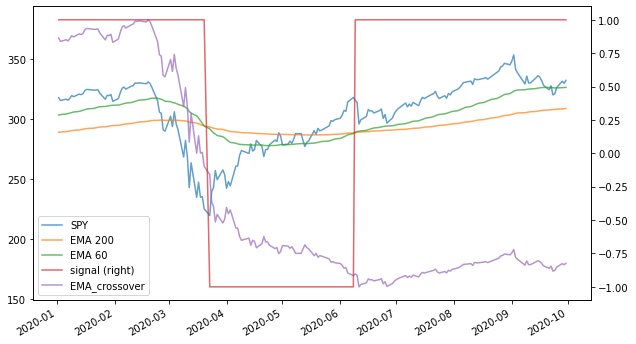

In [82]:
pd.concat([bind, result.prices], axis = 1)['2020-01':'2020-09'].plot(figsize = (10, 6), secondary_y = ['signal'], alpha = 0.7)
plt.show()

코로나 사태로 인해 2020년 3월부터 미국 주식은 급격하게 하락하기 시작했으며, 3월 중순에는 60일 이동평균선이 200일 이동평균선을 하회함에 따라 숏 신호가 발생하였습니다. 그러나 공교롭게도 해당 시점부터 시장은 바닥을 다지고 엄청난 상승을 보였으며, 전략에서는 숏포지션을 취하고 있는 만큼 손실이 발생하기 시작합니다. 6월이 되서야 다시 골든크로스가 발생하여 롱 포지션으로 전환하였지만, 불과 3달동안 복구할 수 없을 정도의 손실을 입게 됩니다.

실제로 추세추종 전략을 사용하는 많은 펀드들이 실제로 2020년 3월부터 6월까지 막대한 손실을 입었습니다. 2020년 초반에는 롱 포지션에서 손실을 입고, 3월부터는 숏포지션에서 손실을 입어 양방향에서 모두 손실을 입은 것입니다.

만일 롱온리 전략을 택했다면 3월부터 6월까지 단순히 수익을 얻지 못한것에 그쳤겠지만, 숏 포지션으로 인해 손실이 배가 된 것입니다. 이처럼 숏 베팅은 하락 시장에서도 돈을 벌 수 있게 해주지만, 예상치 못한 급반등이 나올 경우 손실을 입히는 양날의 검이 되기도 합니다. 이를 방지하기 위해 트레이딩에서는 다양한 신호의 결합, 손실제한(스탑로스, 로스컷) 등을 추가하기도 합니다.

## 16.5 평균회귀 전략 백테스트

추세추종 전략은 주가가 동일한 방향으로 지속된다고 보는 반면, 평균회귀 전략은 주가가 평균으로 회귀한다고 보면 이에 베팅합니다. 주가가 무한정 한방향으로 지속될 수는 없기에 추세추종 전략과 평균회귀 전략을 잘 조합할 필요가 있습니다.

### 16.5.1 RSI를 이용한 전략

RSI는 일정기간 동안 주가의 상승폭과 하락폭의 크기를 비교해 상승과 하락의 상대적인 강도를 나타낸 지표로써, 일반적으로 RSI가 70 이상일 경우 과매수 구간으로써 매도할 때를, 30 이하일 경우 과매도 구간으로써 매수해야 할 때로 여겨집니다. 이에 대한 백테스트를 실행해보도록 하겠습니다.

In [160]:
import talib

data = prices[['SPY']]
spy_rsi = data.apply(lambda x: talib.RSI(x, 14))

signal = spy_rsi.copy()
signal[spy_rsi > 70] = -1
signal[spy_rsi < 30] = 1
signal[(spy_rsi <= 70) & (spy_rsi >= 30)] = 0
signal[signal.isnull()] = 0

먼저 `apply()` 함수 내부에 `RSI()`을 이용해 14일 기준 RSI를 구합니다. 그 후 RSI가 70을 초과하면 -1(숏 포지션), 30 미만이면 1(롱 포지션), 30과 70 사이면 0(뉴트럴)인 신호를 만듭니다.

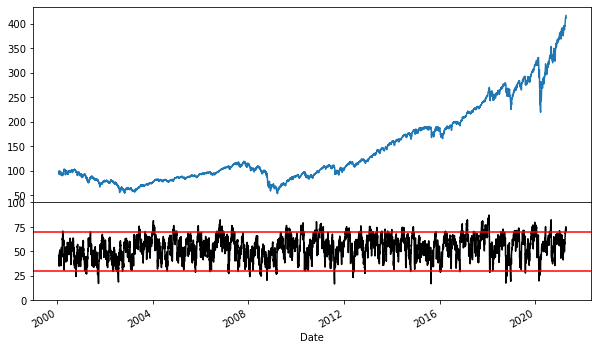

In [169]:
from matplotlib import gridspec

fig = plt.subplots(figsize = (10, 6), sharex = True)
gs = gridspec.GridSpec(nrows = 2, ncols = 1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax1 = data['SPY'].plot()
ax1.set_xlabel('')
ax1.axes.xaxis.set_ticks([])

ax2 = plt.subplot(gs[1])
ax2 = spy_rsi['SPY'].plot(color = 'black', ylim = [0, 100])
ax2 = plt.axhline(y = 30, color = 'red', linestyle = '-')
ax2 = plt.axhline(y = 70, color = 'red', linestyle = '-')

plt.subplots_adjust(wspace = 0, hspace=0)
plt.show()

위 그래프는 주가를 나타내며, 아래 그래프는 RSI를 나타냅니다. 이제 만들어진 신호를 바탕으로 백테스트를 실핻해보겠습니다.

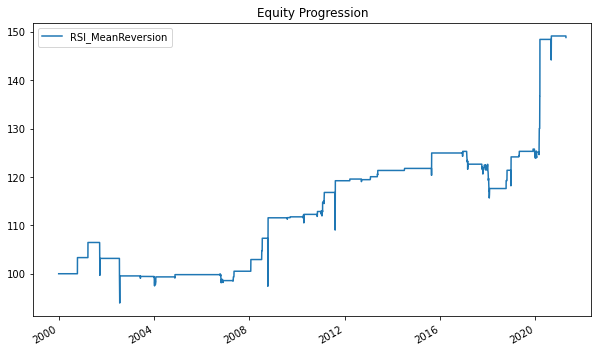

In [159]:
strategy = bt.Strategy('RSI_MeanReversion', 
                       [bt.algos.WeighTarget(signal),
                        bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize = (10, 6))
plt.show()

RSI를 이용하여 트레이딩을 할 경우 장기간으로 큰 손실없이 잘 작동하지만, 과매수 혹은 과매도로 인한 투자 신호가 나타나는 경우가 드물어 누적수익률 자체도 그렇게 높지 않습니다. 반면 2020년의 경우 추세추종 전략과는 반대로 3월 급락장에서 과매도 신호로 인해 매수를 함으로써, 반등으로 인해 상당한 수익을 거두기도 합니다. 이처럼 추세추종과 평균회귀는 서로 상반댄 특징이 있으므로, 이를 잘 조합하면 훨씬 안정적인 수익을 거둘 수 있는 트레이딩 전략을 개발할 수도 있습니다.

### 16.5.2 볼린저 밴드를 이용한 전략

이번에는 볼린저 밴드를 이용한 평균회귀 전략을 백테스트 해보도록 하겠습니다. 볼린저밴드는 이동평균선을 중심으로 일정 표준편차를 상한선과 하한선으로 설정한 밴드입니다. 주가가 정규분포를 따른다면 주가의 움직임은 상한선과 하한선으로 구성된 밴드 내에서만 움직일 확률이 높습니다. 따라서 주가가 상한선 위에 있다는 것은 과매수 상태이므로 하락할 가능성이 높으르로 숏 포지션을, 하단선 아래에 있다는 것은 과매도 상태이므로 상승할 가능성이 높으므로 롱 포지션을 취합니다.

In [179]:
upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data['SPY'],
                                             nbdevup = 2,
                                             nbdevdn = 2,
                                             timeperiod = 20)

bb = pd.concat([upper_2sd, mid_2sd, lower_2sd, data['SPY']], axis = 1)
bb.columns = ['Upper Band', 'Mid Band', 'Lower Band', 'SPY']

`BBANDS()` 함수를 이용해 20일 기준 2 표준편차에 해당하는 볼린저 밴드의 상, 중, 하단 값을 계산한 후 하나의 데이터프레임으로 묶어줍니다.

In [195]:
signal = data.copy()
signal['SPY'] = np.nan

signal[bb['SPY'] > bb['Upper Band']] = -1
signal[bb['SPY'] < bb['Lower Band']] = 1
signal[signal.isnull()] = 0

주가가 상한선 위에 있을 경우 -1(숏 포지션), 주가가 하한선 아래에 있을 경우 1(롱 포지션), 그 외의 경우 0(뉴트럴)의 신호를 만듭니다. 해당 신호를 바탕으로 백테스트를 실핻해보겠습니다.

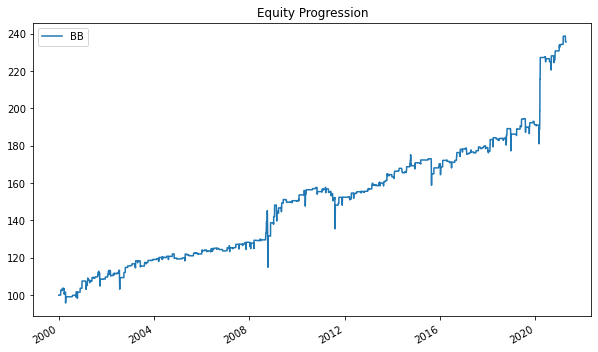

In [199]:
strategy = bt.Strategy('BB', 
                       [bt.algos.WeighTarget(signal),
                        bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize = (10, 6))
plt.show()

RSI와 마찬가지로 0볼린저밴드를 이용한 평균회귀 트레이딩을 할 경우에도 장기간으로 큰 손실없이 잘 작동합니다. 또한 RSI 대비 투자 신호도 자주 발생해 누적 수익률 역시 높습니다.

```{note}
위에서 백테스트한 추세추종과 평균회귀 전략의 경우 신호가 발생하면 해당일 종가에 포지션을 취한다고 가정했습니다. 그러나 현실에서는 종가 직전까지 발생한 신호를 바탕으로 종가에 매매를 하거나 종가로 계산된 신호를 바탕으로 다음날 시가에 매매를 해야하므로, 백테스트의 수익률과 실제 수익률은 상당히 차이가 있을 수 있습니다. 매매수수료의 경우도 백테스트의 수익률과 실제 수익률간 차이를 발생시키는 원인이 될 수 있지만, 선물을 이용할 경우 수수료나 시장 충격은 거의 없다고 봐도 무방합니다.
```

## 16.6 타겟 볼(Target Volatility) 전략

1. 변동성과 수익률의 역관계 (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=709623
2. volatility clustering

https://quantpedia.com/an-introduction-to-volatility-targeting/

### 16.6.1 타겟볼 구현하기

In [169]:
import numpy as np

data = prices[['SPY']]
vol = data.pct_change().std()*np.sqrt(255)

print(vol)

SPY    0.19955
dtype: float64


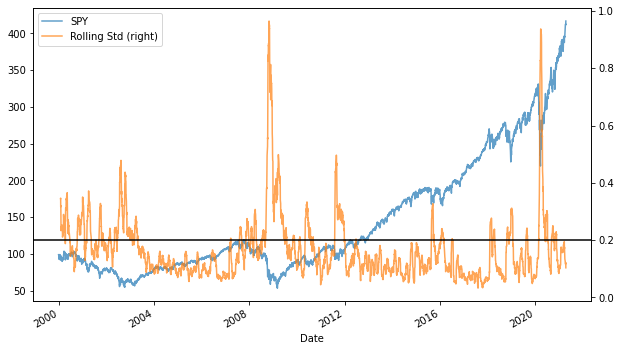

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline

roll_std = data.pct_change().rolling(20).std()*np.sqrt(255)
roll_std.columns = ['Rolling Std']

pd.concat([data, roll_std], axis = 1).plot(figsize = (10, 6), alpha = 0.7,
                                           secondary_y = ['Rolling Std'])
plt.axhline(y = vol.values, color='black', linestyle='-')
plt.show()

In [239]:
import bt

tv = bt.Strategy('Target Vol',
                 [bt.algos.SelectAll(),                                    
                  bt.algos.WeighEqually(),                  
                  bt.algos.TargetVol(0.20, pd.DateOffset(months = 1), lag=pd.DateOffset(days = 1)),
                  bt.algos.RunWeekly(),
                  bt.algos.Rebalance()])
tv_backtest = bt.Backtest(tv, data)
tv_result = bt.run(tv_backtest)

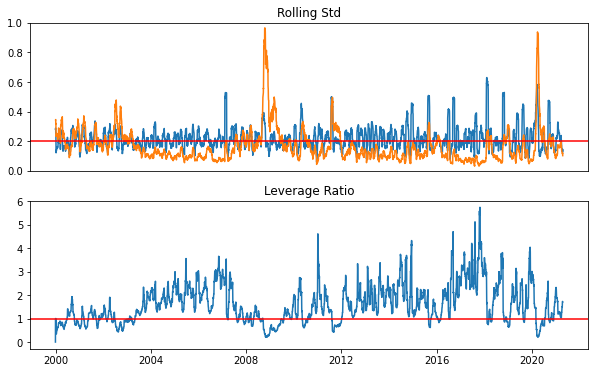

In [242]:
tv_vol = tv_result.prices.to_returns().rolling(20).std()*np.sqrt(255)
tv_wt = tv_result.get_security_weights()

fig = plt.subplots(figsize = (10, 6))

plt.subplot(2, 1, 1)
plt.xticks([])
plt.plot(tv_vol, label = 'Target Vol')
plt.plot(roll_std, label = 'Buy and Hold')
plt.axhline(y = 0.20, color = 'red', linestyle = '-')
plt.ylim(0, 1)
plt.title('Rolling Std')

plt.subplot(2, 1, 2)
plt.plot(tv_wt)
plt.axhline(y = 1, color = 'red', linestyle = '-')
plt.title('Leverage Ratio')

plt.show()

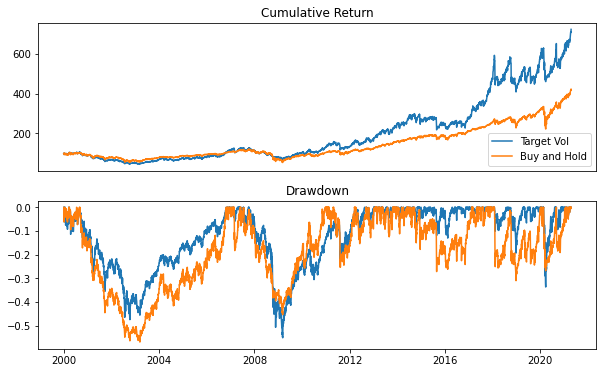

In [220]:
ret_bind = pd.concat([data, tv_result.prices], axis = 1).dropna().rebase()

fig = plt.subplots(figsize = (10, 6))

plt.subplot(2, 1, 1)
plt.xticks([])
plt.plot(ret_bind[['Target Vol']], label = 'Target Vol')
plt.plot(ret_bind[['SPY']], label = 'Buy and Hold')
plt.legend(loc="lower right")
plt.title('Cumulative Return')

plt.subplot(2, 1, 2)
plt.plot(ret_bind.to_drawdown_series(), label = 'Leverage Ratio')
plt.title('Drawdown')

plt.show()

### 16.6.2 캡 씌우기

In [224]:
tv_wt = tv_result.get_security_weights().copy()
tv_wt[tv_wt >= 2] = 2
tv_wt[tv_wt <= 0.5] = 0.5

In [225]:
tv_cap = bt.Strategy('Target Vol (Cap)',
                 [bt.algos.WeighTarget(tv_wt),                    
                  bt.algos.RunWeekly(),
                  bt.algos.Rebalance()])
tv_backtest_cap = bt.Backtest(tv_cap, data)
tv_result_cap = bt.run(tv_backtest_cap)

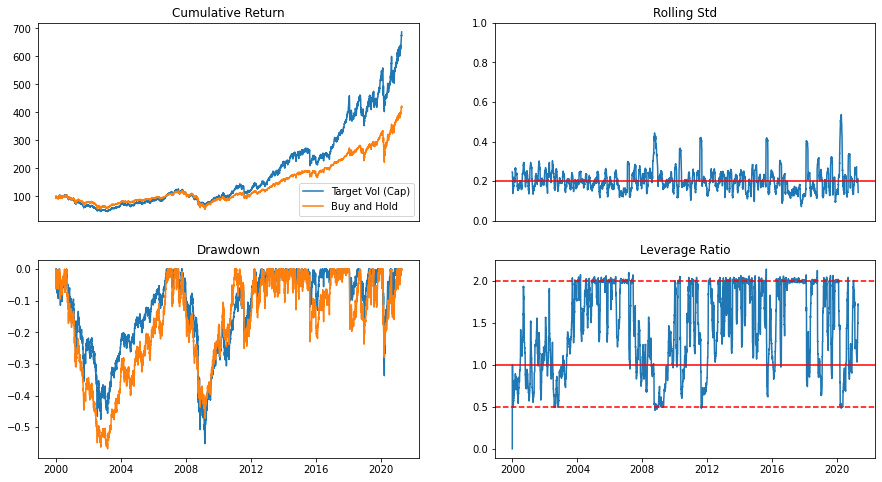

In [233]:
ret_bind_cap = pd.concat([data, tv_result_cap.prices], axis = 1).dropna().rebase()
tv_vol_cap = tv_result_cap.prices.to_returns().rolling(30).std()*np.sqrt(255)
tv_wt_cap = tv_result_cap.get_security_weights()

fig = plt.subplots(figsize = (15, 8))

plt.subplot(2, 2, 1)
plt.xticks([])
plt.plot(ret_bind_cap[['Target Vol (Cap)']], label = 'Target Vol (Cap)')
plt.plot(ret_bind_cap[['SPY']], label = 'Buy and Hold')
plt.legend(loc="lower right")
plt.title('Cumulative Return')

plt.subplot(2, 2, 3)
plt.plot(ret_bind_cap.to_drawdown_series())
plt.title('Drawdown')

plt.subplot(2, 2, 2)
plt.xticks([])
plt.plot(tv_vol_cap)
plt.axhline(y = 0.20, color = 'red', linestyle = '-')
plt.ylim(0, 1)
plt.title('Rolling Std')


plt.subplot(2, 2, 4)
plt.plot(tv_wt_cap)
plt.axhline(y = 1, color = 'red', linestyle = '-')
plt.axhline(y = 2, color = 'red', linestyle = '--')
plt.axhline(y = 0.5, color = 'red', linestyle = '--')
plt.title('Leverage Ratio')

plt.show()